<!-- ## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session -->

## Neural Network from scratch
* Two hidden layers
* Used tanh,relu,softmax activation functions.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn.model_selection as model_selection 
import sklearn.preprocessing as preprocessing 
import sklearn.metrics as metrics 
from tqdm import tqdm

In [2]:
X_train = pd.read_csv("/kaggle/input/assignment2task1dset/train_X.csv",index_col=0).to_numpy()
y_train = pd.read_csv("/kaggle/input/assignment2task1dset/train_y.csv",index_col=0).to_numpy().reshape(-1,)
X_test = pd.read_csv("/kaggle/input/assignment2task1dset/test_X.csv",index_col=0).to_numpy()
submissions_df = pd.read_csv("/kaggle/input/assignment2task1dset/sample_submission.csv",index_col=0)

In [3]:
print("X_train shape:",X_train.shape)
print("Y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("submissions_df shape:",submissions_df.shape)

X_train shape: (60000, 784)
Y_train shape: (60000,)
X_test shape: (10000, 784)
submissions_df shape: (10000, 1)


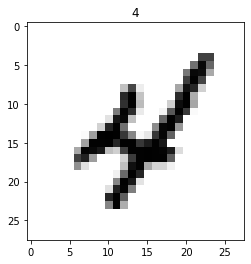

In [4]:
index = 9
plt.title((y_train[index]))
plt.imshow(X_train[index].reshape(28,28), cmap=cm.binary)

In [5]:
print("train data")
y_value = np.zeros((1,10))
for i in range (10):
    print("occurance of ",i,"=",np.count_nonzero(y_train==i))
    y_value[0,i-1] =  np.count_nonzero(y_train==i)

train data
occurance of  0 = 5923
occurance of  1 = 6742
occurance of  2 = 5958
occurance of  3 = 6131
occurance of  4 = 5842
occurance of  5 = 5421
occurance of  6 = 5918
occurance of  7 = 6265
occurance of  8 = 5851
occurance of  9 = 5949


<BarContainer object of 10 artists>

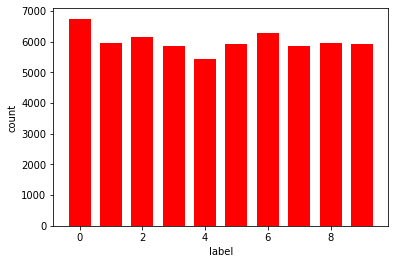

In [6]:
y_value = y_value.ravel()
x_value = [0,1,2,3,4,5,6,7,8,9]
plt.xlabel('label')
plt.ylabel('count')
plt.bar(x_value,y_value,0.7,color='red')

In [7]:
# one hot encoding of label y

Y_train = np.zeros((10,60000))
for column in range(60000):
    v = y_train[column]
    for row in range(10):
        if(v==row):
            Y_train[v,column] = 1
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)

X_train shape: (60000, 784)
Y_train shape: (10, 60000)


In [8]:
#  transpose of x

X_train=X_train.T
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)


X_train shape: (784, 60000)
Y_train shape: (10, 60000)


# **Activation Functions**

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp_X = np.exp(x)
    Z = exp_X / np.sum(exp_X,axis = 0)
    return Z

**Derivative of activation functions**

In [10]:
def deri_relu(x):
    return np.array(x > 0 , dtype = np.float32)

def deri_tanh(x):
    t = tanh(x)
    return (1-(np.power(t,2)))

def deri_sigmoid(x):
    s = sigmoid(x)
    return s * (1-s)



# **Initialization**

In [11]:
def initlz_params(n_i, n_h1, n_h2, n_o):
    w1 = np.random.randn(n_h1, n_i)*0.001
    b1 = np.zeros((n_h1, 1))
    
    w2 = np.random.randn(n_h2, n_h1)*0.001
    b2 = np.zeros((n_h2, 1))
    
    w3 = np.random.randn(n_o, n_h2)*0.001
    b3 = np.zeros((n_o, 1))

    params = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2,
        "w3" : w3,
        "b3" : b3
    }
    
    return params

# **Forward Propogation**

In [12]:
def fwd_prop(x, params):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    w3 = params['w3']
    b3 = params['b3']
    
    z1 = np.dot(w1, x) + b1
    a1 = tanh(z1)
    
    z2 = np.dot(w2, a1) + b2
    a2 = relu(z2)
    
    z3 = np.dot(w3, a2) + b3
    a3 = softmax(z3)
    
    fwd_var = {
        "z1" : z1,
        "a1" : a1,
        "z2" : z2,
        "a2" : a2,
        "z3" : z3,
        "a3" : a3
    }
    
    return fwd_var

In [13]:
# print(Y_train.shape)
# print(a3.shape)

# **Cost Function**

In [14]:
def cost_function(a3, y):
    m = y.shape[1]
    
    cost = -(1/m)*np.sum(y*np.log(a3))
    
    #cost = -(1/m)*np.sum(np.sum(y*np.log(a2, 0), 1))
    
    return cost

# **Backpropogation**

In [15]:
def backward_prop(x, y, params, fwd_var):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    w3 = params['w3']
    b3 = params['b3']
    
    a1 = fwd_var['a1']
    a2 = fwd_var['a2']
    a3 = fwd_var['a3']
    
    m = x.shape[1]
    
    dz3 = (a3-y)
    dw3 = (1/m)*np.dot(dz3, a2.T)
    db3 = (1/m)*np.sum(dz3, axis = 1, keepdims = True)
    
    dz2 = (1/m)*np.dot(w3.T, dz3)*deri_relu(a2)
    dw2 = (1/m)*np.dot(dz2, a1.T)
    db2 = (1/m)*np.sum(dz2, axis = 1, keepdims = True)
    
    dz1 = (1/m)*np.dot(w2.T, dz2)*deri_tanh(a1)
    dw1 = (1/m)*np.dot(dz1, x.T)
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    grads = {
        "dw1" : dw1,
        "db1" : db1,
        "dw2" : dw2,
        "db2" : db2,
        "dw3" : dw3,
        "db3" : db3
    }
    
    return grads

# **Parameters update**

In [16]:
def update_params(params, grads, learning_rate):
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']
    w3 = params['w3']
    b3 = params['b3']    
    
    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']
    dw3 = grads['dw3']
    db3 = grads['db3']
    
    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2
    w3 = w3 - learning_rate*dw3
    b3 = b3 - learning_rate*db3
    
    params = {
        "w1" : w1,
        "b1" : b1,
        "w2" : w2,
        "b2" : b2,
        "w3" : w3,
        "b3" : b3
    }
    
    return params

# **Neural Network**

In [17]:
def model(x, y, n_h1, n_h2, learning_rate, iterations):
    
    n_i = x.shape[0]
    n_o = y.shape[0]
    
    cost_list = []
    
    params = initlz_params(n_i, n_h1,n_h2, n_o)
    
    for i in range(iterations):
        
        fwd_var = fwd_prop(x, params)
        
        cost = cost_function(fwd_var['a3'], y)
        
        grads = backward_prop(x, y, params, fwd_var)
        
        params = update_params(params, grads, learning_rate)
        
        cost_list.append(cost)
        
        if(i%(iterations/10) == 0):
            print("Cost after", i, "iterations is :", cost)
        
    return params, cost_list

In [22]:
iterations = 500
n_h1 = 1000
n_h2 = 500
learning_rate = 0.95
Parameters, Cost_list = model(X_train, Y_train, n_h1 = n_h1, n_h2 = n_h2, learning_rate = learning_rate, iterations = iterations)

Cost after 0 iterations is : 2.302609725112173
Cost after 50 iterations is : 2.240416101320512
Cost after 100 iterations is : 2.1713305709311643
Cost after 150 iterations is : 2.084388067442679
Cost after 200 iterations is : 1.972116033365918
Cost after 250 iterations is : 1.8328035902568263
Cost after 300 iterations is : 1.6736436868770967
Cost after 350 iterations is : 1.508508074968876
Cost after 400 iterations is : 1.35140342754397
Cost after 450 iterations is : 1.2114968977499618


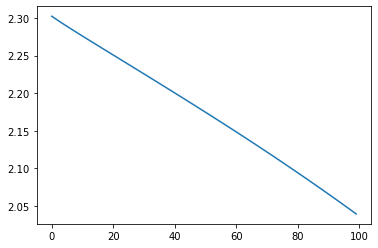

In [19]:
t = np.arange(0, iterations)
plt.plot(t, Cost_list)
plt.show()

In [20]:
def accuracy(inp, labels, params):
    fwd_var = fwd_prop(inp, params)
    a_out = fwd_var['a3']   # containes propabilities with shape(10, 1)
    
    a_out = np.argmax(a_out, 0)  # 0 represents row wise 
    
    labels = np.argmax(labels, 0)
    
    acc = np.mean(a_out == labels)*100
    
    return acc

In [21]:
print("Accuracy of Train Dataset", accuracy(X_train, Y_train, Parameters), "%")

Accuracy of Train Dataset 65.28 %


tanh+relu+softmax
* alpha=0.02 50 itr 11.25
* alpha=0.03 200 itr 11.44
* alpha=0.5 100 itr 0.55.63
* alpha=0.6 100 itr 59.145
* alpha=0.8 100 itr 62.21
* aplha=0.95 100 itr 66.46
* alpha=0.95 200 itr 73.035
* alpha=0.95 400 itr 80.495
* alpha=0.95 500 itr 82.72
